Dataset shape: (891, 12)
Columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
Epoch 0/2000 loss: 0.632416
Epoch 200/2000 loss: 0.444255
Epoch 400/2000 loss: 0.444255
Epoch 600/2000 loss: 0.444255
Epoch 800/2000 loss: 0.444255
Epoch 1000/2000 loss: 0.444255
Epoch 1200/2000 loss: 0.444255
Epoch 1400/2000 loss: 0.444255
Epoch 1600/2000 loss: 0.444255
Epoch 1800/2000 loss: 0.444255

=== Results ===
Train accuracy: 0.7978
Test accuracy: 0.7765
Confusion matrix (test):
 [[93 21]
 [19 46]]
Precision: 0.6866, Recall: 0.7077, F1: 0.6970
ROC AUC (test): 0.8696


/tmp/ipython-input-3264350535.py:127: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(loss) + float(reg)
/tmp/ipython-input-3264350535.py:106: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tprs_sorted, fprs_sorted)


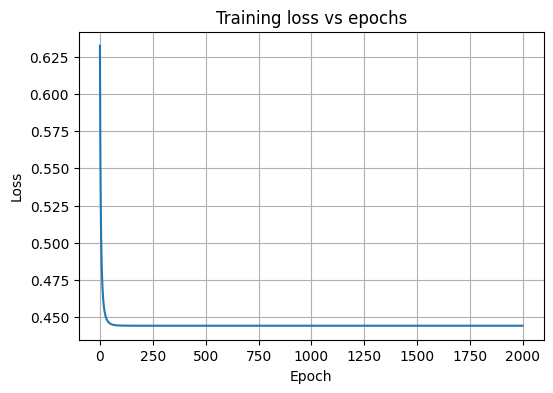

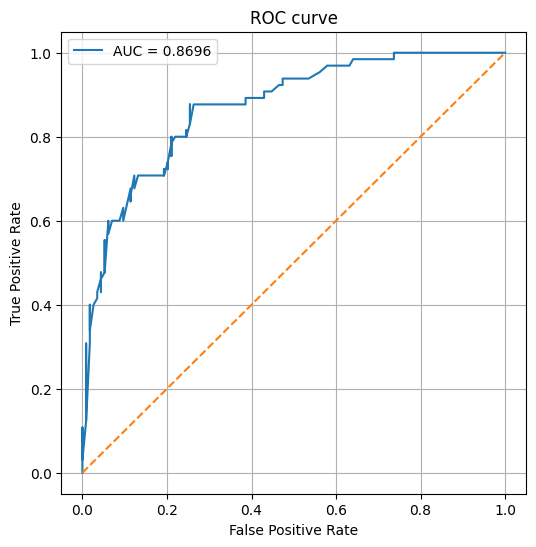

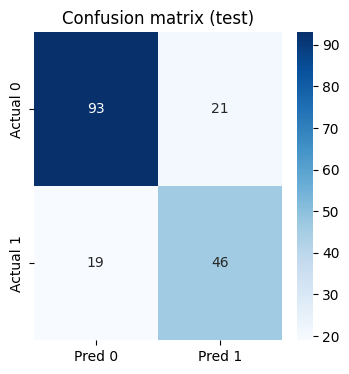


Model weights (including bias):
 0 | bias            | -0.615859
 1 | Pclass          | -0.908817
 2 | Sex             | 1.269226
 3 | Age             | -0.571996
 4 | SibSp           | -0.421459
 5 | Parch           | -0.044580
 6 | Fare            | 0.133183
 7 | Embarked_Q      | -0.058770
 8 | Embarked_S      | -0.137030


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load & preprocess

data = pd.read_csv("titanic.csv")
print("Dataset shape:", data.shape)
print("Columns:", list(data.columns))

# drop identifiers / text columns we don't use for baseline

data = data.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, errors='ignore')

# fill missing values

data["Age"] = data["Age"].fillna(data["Age"].median())
data["Fare"] = data["Fare"].fillna(data["Fare"].median())
data["Embarked"] = data["Embarked"].fillna(data["Embarked"].mode()[0])

# encode categorical

data["Sex"] = data["Sex"].map({"male": 0, "female": 1})
data = pd.get_dummies(data, columns=["Embarked"], drop_first=True)

# keep feature names for later interpretation

features = [c for c in data.columns if c != "Survived"]

# features and target

X = data.drop("Survived", axis=1).values.astype(float)
y = data["Survived"].values.reshape(-1, 1).astype(float)

# Standardize

X_mean = X.mean(axis=0, keepdims=True)
X_std = X.std(axis=0, keepdims=True)
X_std[X_std == 0] = 1.0
X_scaled = (X - X_mean) / X_std

# Add bias column (intercept)

X_scaled_bias = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])

# Train/test split (80/20)

np.random.seed(42)
indices = np.arange(X_scaled_bias.shape[0])
np.random.shuffle(indices)
split = int(0.8 * len(indices))
train_idx = indices[:split]
test_idx = indices[split:]

X_train = X_scaled_bias[train_idx]
y_train = y[train_idx]
X_test = X_scaled_bias[test_idx]
y_test = y[test_idx]

# Utility functions

def sigmoid(z):
# numerically stable sigmoid
  return 1 / (1 + np.exp(-z))

# metrics

def accuracy_score(y_true, y_pred):
  return np.mean(y_true.flatten() == y_pred.flatten())

def confusion_matrix_fn(y_true, y_pred):
  tp = int(((y_true == 1) & (y_pred == 1)).sum())
  tn = int(((y_true == 0) & (y_pred == 0)).sum())
  fp = int(((y_true == 0) & (y_pred == 1)).sum())
  fn = int(((y_true == 1) & (y_pred == 0)).sum())
  return np.array([[tn, fp],
                   [fn, tp]])

def precision_recall_f1(y_true, y_pred):
  cm = confusion_matrix_fn(y_true, y_pred)
  tn, fp, fn, tp = cm.ravel()[0], cm.ravel()[1], cm.ravel()[2], cm.ravel()[3]
  precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
  recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
  f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
  return precision, recall, f1

def roc_curve_and_auc(y_true, y_scores, num_thresholds=200):
  thresholds = np.linspace(0, 1, num_thresholds)
  tprs = []
  fprs = []
  for t in thresholds:
    preds = (y_scores >= t).astype(int)
    cm = confusion_matrix_fn(y_true, preds)
    tn, fp, fn, tp = cm.ravel()[0], cm.ravel()[1], cm.ravel()[2], cm.ravel()[3]
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    tprs.append(tpr)
    fprs.append(fpr)
  fprs = np.array(fprs)
  tprs = np.array(tprs)
  order = np.argsort(fprs)
  fprs_sorted = fprs[order]
  tprs_sorted = tprs[order]
  auc = np.trapz(tprs_sorted, fprs_sorted)
  return fprs_sorted, tprs_sorted, auc

# Logistic Regression class

class LogisticRegressionScratch:
  def __init__(self, n_features, lr=0.1, epochs=1000, reg_lambda=0.0, verbose=False):
    self.lr = lr
    self.epochs = epochs
    self.reg_lambda = reg_lambda
    self.verbose = verbose
    self.w = np.zeros((n_features, 1), dtype=float)
    self.loss_history = []

  def _loss(self, X, y):
    m = X.shape[0]
    z = X.dot(self.w)
    preds = sigmoid(z)
    eps = 1e-9
    loss = - (1/m) * (y.T.dot(np.log(preds + eps)) + (1 - y).T.dot(np.log(1 - preds + eps)))
    reg = (self.reg_lambda / (2*m)) * np.sum(self.w[1:]**2)
    return float(loss) + float(reg)

  def fit(self, X, y):
    m = X.shape[0]
    for epoch in range(self.epochs):
      z = X.dot(self.w) # shape (m,1)
      preds = sigmoid(z) # shape (m,1)
      error = preds - y # shape (m,1)
      grad = (1/m) * (X.T.dot(error)) # shape (n,1)
      # regularize gradients for weights excluding bias term
      grad[1:] += (self.reg_lambda / m) * self.w[1:]
      self.w -= self.lr * grad
      # record loss
      loss_val = self._loss(X, y)
      self.loss_history.append(loss_val)
      if self.verbose and (epoch % max(1, self.epochs // 10) == 0):
        print(f"Epoch {epoch}/{self.epochs} loss: {loss_val:.6f}")

  def predict_proba(self, X):
    return sigmoid(X.dot(self.w)) # returns (m,1)

  def predict(self, X, threshold=0.5):
    return (self.predict_proba(X) >= threshold).astype(int)

# Train model

n_features = X_train.shape[1]
model = LogisticRegressionScratch(n_features, lr=0.5, epochs=2000, reg_lambda=0.01, verbose=True)
model.fit(X_train, y_train)

# Predictions & Metrics

y_train_proba = model.predict_proba(X_train).flatten()
y_test_proba = model.predict_proba(X_test).flatten()

y_train_pred = (y_train_proba >= 0.5).astype(int).reshape(-1,1)
y_test_pred = (y_test_proba >= 0.5).astype(int).reshape(-1,1)

train_acc = accuracy_score(y_train.flatten(), y_train_pred.flatten())
test_acc = accuracy_score(y_test.flatten(), y_test_pred.flatten())
cm_test = confusion_matrix_fn(y_test.flatten(), y_test_pred.flatten())
precision, recall, f1 = precision_recall_f1(y_test.flatten(), y_test_pred.flatten())
fprs, tprs, auc_val = roc_curve_and_auc(y_test.flatten(), y_test_proba, num_thresholds=300)

print("\n=== Results ===")
print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")
print("Confusion matrix (test):\n", cm_test)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
print(f"ROC AUC (test): {auc_val:.4f}")

# Plots

plt.figure(figsize=(6,4))
plt.plot(model.loss_history)
plt.title("Training loss vs epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,6))
plt.plot(fprs, tprs, label=f"AUC = {auc_val:.4f}")
plt.plot([0,1],[0,1], linestyle='--')
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(4,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
xticklabels=['Pred 0','Pred 1'], yticklabels=['Actual 0','Actual 1'])
plt.title("Confusion matrix (test)")
plt.show()

# print weights (interpretation)
print("\nModel weights (including bias):")
feat_names_with_bias = ["bias"] + features
for i, val in enumerate(model.w.flatten()):
  name = feat_names_with_bias[i] if i < len(feat_names_with_bias) else f"w{i}"
  print(f"{i:2d} | {name:15s} | {val:.6f}")